<a href="https://colab.research.google.com/github/noorsaba5/Analysing-Data/blob/main/scraping_stock_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Import Required Modules


import yfinance as yf                 # For fetching financial data
import pandas as pd                  # For data manipulation
import numpy as np                   # For numerical operations
import matplotlib.pyplot as plt      # For plotting
import seaborn as sns                # For enhanced visualization
import sqlite3                       # For in-memory SQL-based operations
from statsmodels.tsa.arima.model import ARIMA  # For time-series forecasting


# Stock and Crypto Fetching


# Download historical stock data from Yahoo Finance
def fetch_stock_data(tickers, period="6mo"):
    data = yf.download(tickers, period=period, group_by='ticker', auto_adjust=True)
    return data

# Display detailed information for a specific stock
def fetch_additional_info(ticker):
    stock = yf.Ticker(ticker)
    print(f"\nFetching additional data for {ticker}...")
    print("Market Cap:", stock.info.get("marketCap", "N/A"))
    print("P/E Ratio:", stock.info.get("trailingPE", "N/A"))
    print("Dividend Yield:", stock.info.get("dividendYield", "N/A"))
    print("Recent Dividends:\n", stock.dividends.tail())
    print("Stock Splits:\n", stock.splits.tail())
    print("Financials:\n", stock.financials.head())
    print("Balance Sheet:\n", stock.balance_sheet.head())
    print("Cash Flow Statement:\n", stock.cashflow.head())
    print("Analyst Recommendations:\n", stock.recommendations.tail())
    if stock.options:
        print("Available Option Expiration Dates:", stock.options)

# Fetch recent data for a cryptocurrency
def fetch_crypto_data(crypto_ticker):
    crypto = yf.Ticker(crypto_ticker)
    print(f"\nFetching cryptocurrency data for {crypto_ticker}...")
    print(crypto.history(period="1mo"))

# Save any DataFrame to a CSV file
def save_to_csv(data, filename):
    data.to_csv(filename)
    print(f"Data saved to {filename}")


# Dashboard Visualization


# Build and display plots for multiple aspects of stock behavior
def visualization_dashboard(stock_history, tickers):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18), constrained_layout=True)
    axes = axes.flatten()

    # Closing price trends
    for ticker in tickers:
        stock_history[ticker]['Close'].plot(ax=axes[0], label=f'{ticker} Closing Price')
    axes[0].set_title('Closing Price Trends')
    axes[0].legend()
    axes[0].grid()

    # Correlation matrix of closing prices
    close_prices = pd.DataFrame({ticker: stock_history[ticker]['Close'] for ticker in tickers})
    sns.heatmap(close_prices.corr(), annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Correlation Matrix')

    # Volume trends
    volume = pd.DataFrame({ticker: stock_history[ticker]['Volume'] for ticker in tickers})
    volume.plot(ax=axes[2])
    axes[2].set_title('Trading Volume Trends')

    # Daily returns
    daily_returns = close_prices.pct_change()
    daily_returns.plot(ax=axes[3])
    axes[3].set_title('Daily Returns')

    # Daily returns distribution (histograms with KDE)
    for i, ticker in enumerate(tickers[:2]):
        sns.histplot(daily_returns[ticker].dropna(), kde=True, ax=axes[4 + i], color='orange')
        axes[4 + i].set_title(f'{ticker} Daily Returns Distribution')

    plt.show()


# Advanced SQL + ARIMA Analysis


def advanced_analysis():
    # Load previously saved CSVs
    apple_df = pd.read_csv('AAPL_stock_data.csv')
    stocks_df = pd.read_csv('stocks_data.csv', skiprows=2)

    # Rename columns for clarity and consistency
    stocks_df.columns = [
        'Date', 'AAPL_Close', 'GOOGL_Close', 'TSLA_Close',
        'AAPL_High', 'GOOGL_High', 'TSLA_High',
        'AAPL_Low', 'GOOGL_Low', 'TSLA_Low',
        'AAPL_Open', 'GOOGL_Open', 'TSLA_Open',
        'AAPL_Volume', 'GOOGL_Volume', 'TSLA_Volume'
    ]

    # Convert date columns to datetime format
    apple_df['Date'] = pd.to_datetime(apple_df['Date'], utc=True).dt.tz_convert(None)
    stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

    # Create in-memory SQLite database and load data
    conn = sqlite3.connect(':memory:')
    apple_df.to_sql('apple_stock', conn, index=False)
    stocks_df.to_sql('stocks', conn, index=False)

    # Join Apple and other stock data on the same date
    query = """
    SELECT a.Date, a.Open AS AAPL_Open_1, a.High AS AAPL_High_1, a.Low AS AAPL_Low_1, a.Close AS AAPL_Close_1, a.Volume AS AAPL_Volume_1,
           s.AAPL_Open AS AAPL_Open_2, s.AAPL_High AS AAPL_High_2, s.AAPL_Low AS AAPL_Low_2, s.AAPL_Close AS AAPL_Close_2, s.AAPL_Volume AS AAPL_Volume_2,
           s.GOOGL_Open, s.GOOGL_High, s.GOOGL_Low, s.GOOGL_Close, s.GOOGL_Volume,
           s.TSLA_Open, s.TSLA_High, s.TSLA_Low, s.TSLA_Close, s.TSLA_Volume
    FROM apple_stock a
    JOIN stocks s ON date(a.Date) = date(s.Date)
    """
    combined_df = pd.read_sql(query, conn, parse_dates=['Date'])
    combined_df.set_index('Date', inplace=True)

    # Calculate daily percentage returns
    combined_df['AAPL_Return'] = combined_df['AAPL_Close_2'].pct_change()
    combined_df['GOOGL_Return'] = combined_df['GOOGL_Close'].pct_change()
    combined_df['TSLA_Return'] = combined_df['TSLA_Close'].pct_change()

    # Calculate volatility (standard deviation of returns)
    volatility = combined_df[['AAPL_Return', 'GOOGL_Return', 'TSLA_Return']].std()

    # Apply ARIMA model to forecast AAPL prices
    model = ARIMA(combined_df['AAPL_Close_2'].dropna(), order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=15)

    # Value at Risk (VaR) and Conditional VaR (CVaR) calculation
    var_cvar = {}
    confidence = 0.95
    for stock in ['AAPL_Return', 'GOOGL_Return', 'TSLA_Return']:
        var = np.percentile(combined_df[stock].dropna(), (1 - confidence) * 100)
        cvar = combined_df[stock][combined_df[stock] <= var].mean()
        var_cvar[stock] = {'VaR': var, 'CVaR': cvar}

    # Correlation matrix for prices and volume
    corr_matrix = combined_df[['AAPL_Close_2', 'GOOGL_Close', 'TSLA_Close', 'AAPL_Volume_2', 'GOOGL_Volume', 'TSLA_Volume']].corr()


    # Dashboard Visualization


    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    # Heatmap of correlations
    sns.heatmap(corr_matrix, annot=True, ax=axes[0, 0])
    axes[0, 0].set_title('Correlation Matrix')

    # ARIMA Forecast Plot
    forecast.plot(ax=axes[0, 1], title='AAPL Forecast')
    axes[0, 1].set_xlabel('Days')
    axes[0, 1].set_ylabel('Price')

    # Daily Returns Plot
    daily_returns = combined_df[['AAPL_Return', 'GOOGL_Return', 'TSLA_Return']]
    daily_returns.plot(ax=axes[1, 0], title='Daily Returns')

    # Volatility as bar plot
    volatility.plot.bar(ax=axes[1, 1], title='Volatility')

    # Cumulative returns over time
    cumulative_returns = (1 + daily_returns).cumprod()
    cumulative_returns.plot(ax=axes[2, 0], title='Cumulative Returns')

    # Difference between two sources of AAPL closing price
    combined_df['AAPL_Close_Diff'] = combined_df['AAPL_Close_1'] - combined_df['AAPL_Close_2']
    combined_df['AAPL_Close_Diff'].plot(ax=axes[2, 1], marker='o', linestyle='', title='AAPL Closing Price Difference')
    axes[2, 1].axhline(0, color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()
    conn.close()


# Main Execution Block


if __name__ == "__main__":
    # Get stock tickers from user
    tickers = input("Enter stock ticker symbols separated by commas (e.g., AAPL, TSLA, GOOGL): ").split(",")
    tickers = [t.strip().upper() for t in tickers]

    # Fetch and save stock data
    hist = fetch_stock_data(tickers)
    save_to_csv(hist, "stocks_data.csv")

    # Visual analysis dashboard
    visualization_dashboard(hist, tickers)

    # Optional: fetch additional info for each ticker
    for ticker in tickers:
        fetch_additional_info(ticker)

    # Optional: Crypto data
    crypto_ticker = input("Enter cryptocurrency ticker (e.g., BTC-USD) or press Enter to skip: ")
    if crypto_ticker:
        fetch_crypto_data(crypto_ticker)

    # Optional: Run advanced SQLite + ARIMA dashboard
    run_advanced = input("\nDo you want to run the advanced SQLite/ARIMA analysis (requires 'AAPL_stock_data.csv')? [y/n]: ").strip().lower()
    if run_advanced == 'y':
        advanced_analysis()


# Task
Tell me about this dataset.

Here is all the data you need:
"stocks_data.csv"

## Data loading

### Subtask:
Load the provided CSV file into a pandas DataFrame.


**Reasoning**:
Load the CSV file into a pandas DataFrame and display the first 5 rows.



In [1]:
import pandas as pd

df = pd.read_csv('stocks_data.csv')
display(df.head())

,Ticker,GOOGL,GOOGL.1,GOOGL.2,GOOGL.3,GOOGL.4,TSLA,TSLA.1,TSLA.2,TSLA.3,TSLA.4,AAPL,AAPL.1,AAPL.2,AAPL.3,AAPL.4
0,Price,Open,High,Low,Close,Volume,Open,High,Low,Close,Volume,Open,High,Low,Close,Volume
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-09-30,162.9453785886578,165.76887364583845,162.88550343062403,165.46957397460938,20413900,259.0400085449219,264.8599853515625,255.77000427246094,261.6300048828125,80705700,229.53482055042815,232.4883270263672,229.14567760776433,232.4883270263672,54541900
3,2024-10-01,167.30535540779766,168.7719847422779,164.2024885113937,166.60696411132812,28338100,262.6700134277344,263.9800109863281,248.52999877929688,258.0199890136719,87397600,229.01597026460064,229.14567442683443,223.24866456606327,225.71324157714844,63285000
4,2024-10-02,166.03826626655388,167.13574919120185,164.3521403294987,165.47955322265625,17760200,247.5500030517578,251.16000366210938,241.5,249.02000427246094,93983900,225.39393750024195,226.8706831083472,222.5302449869956,226.281982421875,32880600


## Data exploration

### Subtask:
Explore the loaded dataset to understand its characteristics.


**Reasoning**:
Examine the shape, data types, missing values, and distribution of numerical features in the DataFrame.



In [2]:
# Check the shape of the DataFrame.
print("Shape of the DataFrame:", df.shape)

# Check data types of each column.
print("\nData Types:\n", df.dtypes)

# Identify missing values.
print("\nMissing Values:\n", df.isnull().sum())

# Analyze the distribution of numerical features.  Since the first two rows are header rows, let's analyze from the 3rd row onwards.
numerical_cols = ['GOOGL', 'GOOGL.1', 'GOOGL.2', 'GOOGL.3', 'GOOGL.4', 'TSLA', 'TSLA.1', 'TSLA.2', 'TSLA.3', 'TSLA.4', 'AAPL', 'AAPL.1', 'AAPL.2', 'AAPL.3', 'AAPL.4']
df_numeric = df[numerical_cols][2:]

# Attempt to convert to numeric, coercing errors to NaN
for col in numerical_cols:
  df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# Describe the numeric data, excluding the first two header rows
print("\nDescription of Numerical Features:\n", df_numeric.describe())

# Display the first few rows of df_numeric to inspect the data
display(df_numeric.head())

Shape of the DataFrame: (125, 16)

Data Types:
 Ticker     object
GOOGL      object
GOOGL.1    object
GOOGL.2    object
GOOGL.3    object
GOOGL.4    object
TSLA       object
TSLA.1     object
TSLA.2     object
TSLA.3     object
TSLA.4     object
AAPL       object
AAPL.1     object
AAPL.2     object
AAPL.3     object
AAPL.4     object
dtype: object

Missing Values:
 Ticker     0
GOOGL      1
GOOGL.1    1
GOOGL.2    1
GOOGL.3    1
GOOGL.4    1
TSLA       1
TSLA.1     1
TSLA.2     1
TSLA.3     1
TSLA.4     1
AAPL       1
AAPL.1     1
AAPL.2     1
AAPL.3     1
AAPL.4     1
dtype: int64

Description of Numerical Features:
             GOOGL     GOOGL.1     GOOGL.2     GOOGL.3       GOOGL.4  \
count  123.000000  123.000000  123.000000  123.000000  1.230000e+02   
mean   178.070898  180.090789  176.096376  178.083177  2.864908e+07   
std     12.526209   12.858681   12.537334   12.703475  1.173498e+07   
min    160.500990  162.695956  156.720001  160.669998  1.040330e+07   
25%    167.157753  

,GOOGL,GOOGL.1,GOOGL.2,GOOGL.3,GOOGL.4,TSLA,TSLA.1,TSLA.2,TSLA.3,TSLA.4,AAPL,AAPL.1,AAPL.2,AAPL.3,AAPL.4
2,162.945379,165.768874,162.885503,165.469574,20413900,259.040009,264.859985,255.770004,261.630005,80705700,229.534821,232.488327,229.145678,232.488327,54541900
3,167.305355,168.771985,164.202489,166.606964,28338100,262.670013,263.980011,248.529999,258.019989,87397600,229.015970,229.145674,223.248665,225.713242,63285000
4,166.038266,167.135749,164.352140,165.479553,17760200,247.550003,251.160004,241.500000,249.020004,93983900,225.393938,226.870683,222.530245,226.281982,32880600
5,164.032882,166.257763,163.544001,165.479553,15073100,244.479996,249.789993,237.809998,240.660004,80729200,224.645573,226.311904,222.829578,225.174408,34044200
6,167.674494,167.844103,165.100411,166.676788,19047400,246.690002,250.960007,244.580002,250.080002,86573200,227.399516,227.499303,223.637806,226.301941,37245100


## Data analysis

### Subtask:
Calculate descriptive statistics and identify potential correlations between stock features.


**Reasoning**:
Calculate descriptive statistics and the correlation matrix for the numerical features in `df_numeric`, then visualize the correlation matrix using a heatmap.



,GOOGL,GOOGL.1,GOOGL.2,GOOGL.3,GOOGL.4,TSLA,TSLA.1,TSLA.2,TSLA.3,TSLA.4,AAPL,AAPL.1,AAPL.2,AAPL.3,AAPL.4
count,123.000000,123.000000,123.000000,123.000000,1.230000e+02,123.000000,123.000000,123.000000,123.000000,1.230000e+02,123.000000,123.000000,123.000000,123.000000,1.230000e+02
mean,178.070898,180.090789,176.096376,178.083177,2.864908e+07,328.789188,336.249268,319.611152,327.855691,9.381759e+07,233.331186,235.747615,231.147461,233.707120,4.818856e+07
std,12.526209,12.858681,12.537334,12.703475,1.173498e+07,73.815803,75.889349,71.384940,73.664472,3.670321e+07,10.509784,10.440756,10.574354,10.562880,1.749427e+07
min,160.500990,162.695956,156.720001,160.669998,1.040330e+07,217.130005,218.220001,212.110001,213.649994,3.716760e+07,211.250000,213.949997,208.419998,209.679993,2.323470e+07
25%,167.157753,168.281606,164.227433,166.472267,2.044495e+07,257.000000,262.735001,248.889999,257.784988,6.733745e+07,224.887746,227.954086,223.878844,226.291962,3.707995e+07
50%,173.789858,176.414423,173.102028,174.897903,2.538960e+07,341.000000,346.600006,330.010010,337.799988,8.629190e+07,232.588105,234.412271,229.467710,232.619995,4.468600e+07
75%,190.840218,192.518277,188.128331,190.905136,3.238490e+07,392.815002,403.145004,382.904999,394.839996,1.130388e+08,241.722146,243.970909,239.458181,242.163750,5.409175e+07
max,203.156027,206.811821,202.576693,206.142593,7.037390e+07,475.899994,488.540009,457.510010,479.859985,2.105216e+08,257.906429,259.814335,257.347047,258.735504,1.474953e+08


,GOOGL,GOOGL.1,GOOGL.2,GOOGL.3,GOOGL.4,TSLA,TSLA.1,TSLA.2,TSLA.3,TSLA.4,AAPL,AAPL.1,AAPL.2,AAPL.3,AAPL.4
GOOGL,1.000000,0.992408,0.988615,0.978896,0.075781,0.889381,0.884118,0.887548,0.879477,-0.203024,0.499449,0.516660,0.477692,0.483308,0.191071
GOOGL.1,0.992408,1.000000,0.990839,0.990369,0.115883,0.890530,0.887100,0.890642,0.885254,-0.195351,0.501398,0.525562,0.483972,0.493141,0.228203
GOOGL.2,0.988615,0.990839,1.000000,0.993327,0.018198,0.886817,0.882809,0.890011,0.884491,-0.208583,0.488964,0.511903,0.478391,0.488931,0.195688
GOOGL.3,0.978896,0.990369,0.993327,1.000000,0.062268,0.885885,0.883962,0.891627,0.889007,-0.200091,0.487553,0.515004,0.478581,0.494247,0.212290
GOOGL.4,0.075781,0.115883,0.018198,0.062268,1.000000,0.062426,0.069615,0.052544,0.052972,0.125669,0.010250,0.036701,-0.023944,0.000412,0.354003
TSLA,0.889381,0.890530,0.886817,0.885885,0.062426,1.000000,0.996162,0.994748,0.989576,-0.169791,0.618864,0.640458,0.623570,0.628831,0.149719
TSLA.1,0.884118,0.887100,0.882809,0.883962,0.069615,0.996162,1.000000,0.995612,0.994990,-0.136173,0.614919,0.637993,0.620877,0.628344,0.153231
TSLA.2,0.887548,0.890642,0.890011,0.891627,0.052544,0.994748,0.995612,1.000000,0.996179,-0.199288,0.607395,0.630283,0.618135,0.625990,0.135488
TSLA.3,0.879477,0.885254,0.884491,0.889007,0.052972,0.989576,0.994990,0.996179,1.000000,-0.164347,0.603683,0.627541,0.615997,0.626576,0.129472
TSLA.4,-0.203024,-0.195351,-0.208583,-0.200091,0.125669,-0.169791,-0.136173,-0.199288,-0.164347,1.000000,-0.199189,-0.201978,-0.232675,-0.232906,0.122300


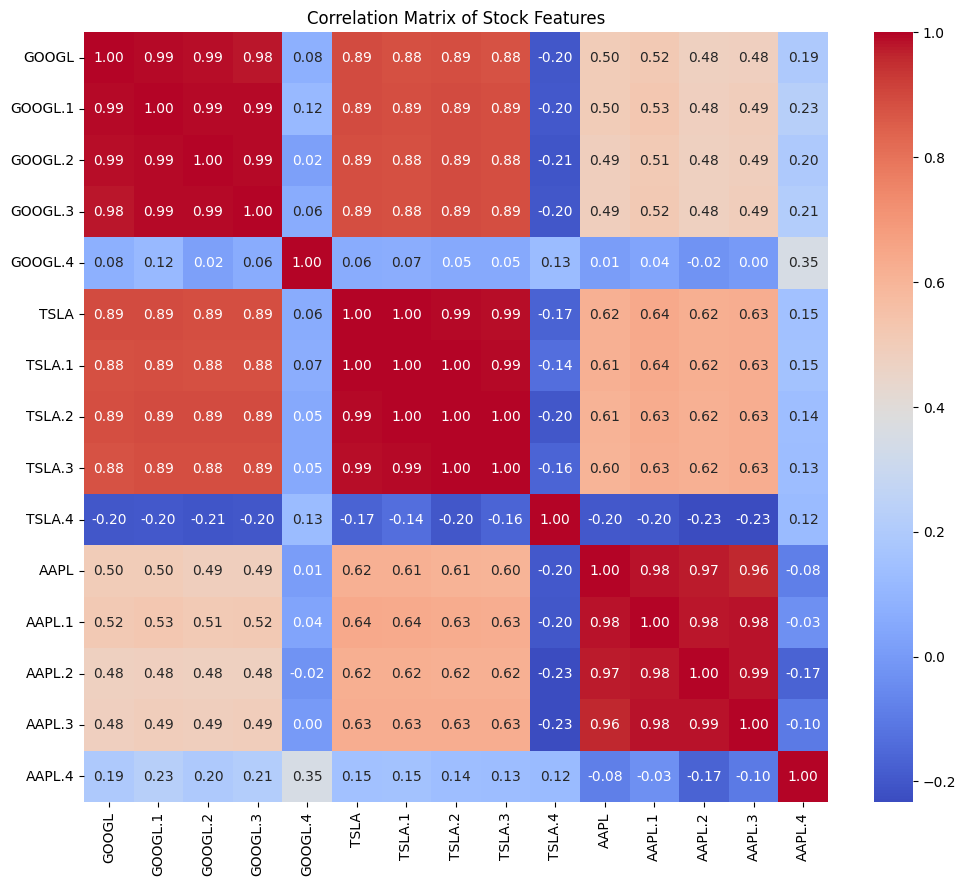

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate descriptive statistics
descriptive_stats = df_numeric.describe()
display(descriptive_stats)

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()
display(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Features')
plt.show()

## Data visualization

### Subtask:
Visualize the distributions of key numerical features and the relationships between pairs of features.


**Reasoning**:
Create histograms, scatter plots, and box plots to visualize the distributions and relationships of key numerical features in `df_numeric`.



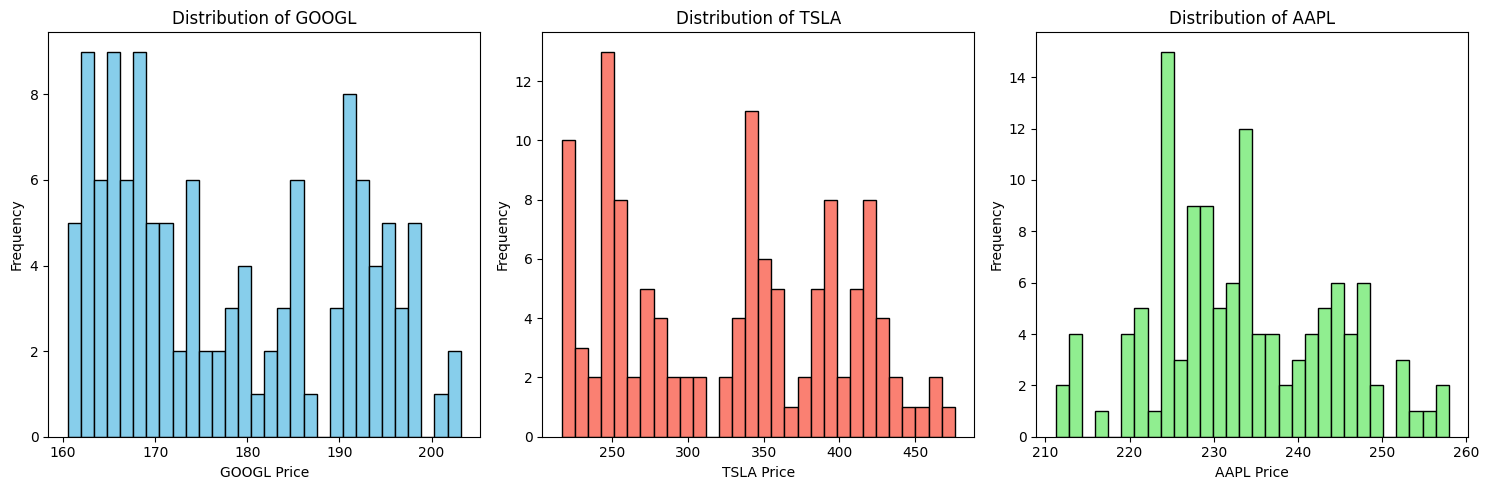

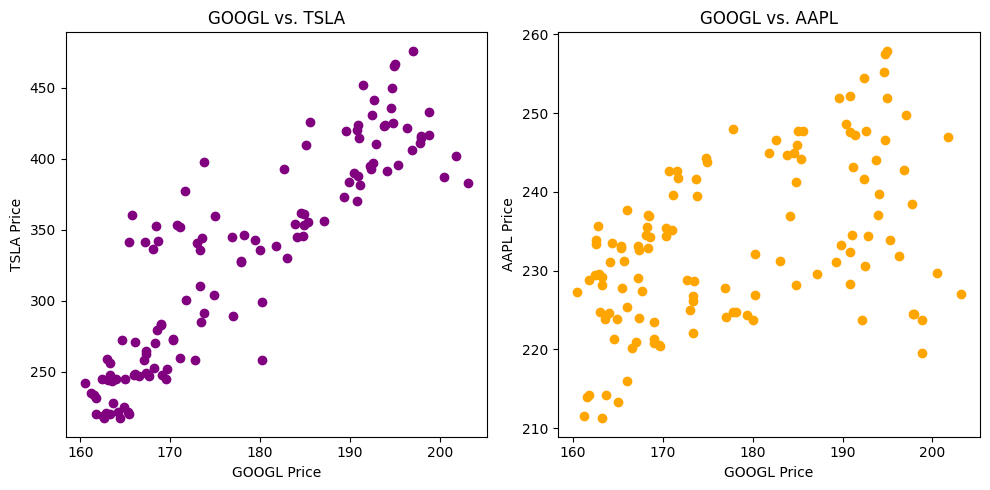

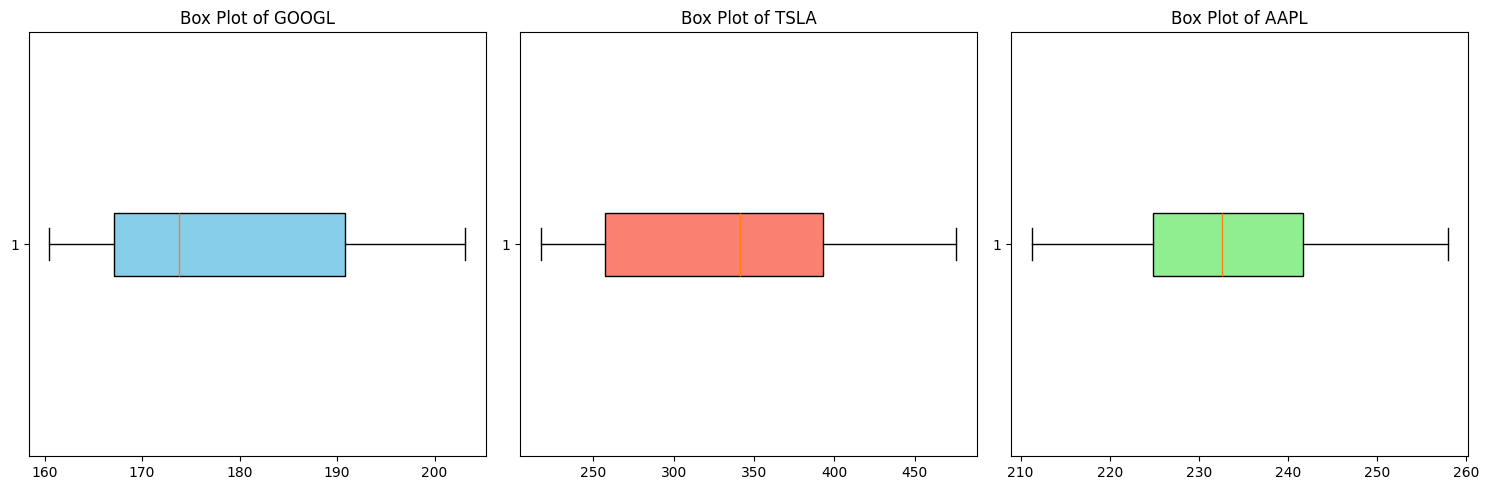

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df_numeric['GOOGL'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of GOOGL')
plt.xlabel('GOOGL Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_numeric['TSLA'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of TSLA')
plt.xlabel('TSLA Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df_numeric['AAPL'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of AAPL')
plt.xlabel('AAPL Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_numeric['GOOGL'], df_numeric['TSLA'], color='purple')
plt.title('GOOGL vs. TSLA')
plt.xlabel('GOOGL Price')
plt.ylabel('TSLA Price')

plt.subplot(1, 2, 2)
plt.scatter(df_numeric['GOOGL'], df_numeric['AAPL'], color='orange')
plt.title('GOOGL vs. AAPL')
plt.xlabel('GOOGL Price')
plt.ylabel('AAPL Price')

plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.boxplot(df_numeric['GOOGL'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Box Plot of GOOGL')

plt.subplot(1, 3, 2)
plt.boxplot(df_numeric['TSLA'], vert=False, patch_artist=True, boxprops=dict(facecolor='salmon'))
plt.title('Box Plot of TSLA')

plt.subplot(1, 3, 3)
plt.boxplot(df_numeric['AAPL'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Box Plot of AAPL')

plt.tight_layout()
plt.show()

## Summary:

### 1. Q&A

Based on the provided data analysis, there are no explicit questions asked in the task description.  However, the analysis implicitly addresses several questions about the dataset:

* **What are the key characteristics of the dataset?**  The analysis reveals the shape, data types, missing values, and descriptive statistics of numerical features.
* **Are there any correlations between the stock prices?** The correlation matrix and heatmap visualizations show relationships between different stock prices.
* **What are the distributions of the stock prices?**  Histograms, scatter plots, and box plots reveal the distributions and relationships between stock prices for Google, Tesla, and Apple.


### 2. Data Analysis Key Findings

* **Data Shape:** The DataFrame has 125 rows and 16 columns.
* **Missing Values:** One missing value was found in each column of the original DataFrame `df`.
* **Strong Positive Correlations:** Strong positive correlations (close to 1) exist between different features of the same stock (e.g., GOOGL, GOOGL.1, GOOGL.2, GOOGL.3), indicating that these features tend to move together. This is also observed for TSLA and AAPL.
* **Weaker Correlations for Volume:** The volume data (columns ending in ".4") exhibit weaker correlations compared to other features.
* **Data Distribution Visualizations:** Histograms, scatter plots, and box plots provide visual insights into the distributions and relationships of 'GOOGL', 'TSLA', and 'AAPL' stock prices, including potential outliers identified in the boxplots.

### 3. Insights or Next Steps

* **Investigate the nature of the missing values:** Determine if the missing values are random or systematic, and consider appropriate imputation methods.  Understanding the cause of the missing data is crucial.
* **Explore time series analysis:**  Given the apparent time series nature of the data (dates are included, as suggested by the initial data load output), a time series analysis could reveal trends, seasonality, and other patterns in the stock prices.  This would provide a more in-depth understanding of the stock's behavior over time.
